In [12]:
import numpy as np
import math, json
from rdp import rdp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import tqdm.notebook as tq
import pickle
from collections import defaultdict
import cairosvg
from PIL import Image,ImageDraw
import glob
import os 
import re
import svgwrite

In [13]:
def get_bounds(data):
    minx, miny = 600, 600  
    maxx, maxy = 0, 0
    
    for i, (x, y, z) in enumerate(data): 
        if minx > x:
            minx = x
        if miny > y:
            miny = y 

        if maxx < x:
            maxx = x
        if maxy < y:
            maxy = y 
    return minx, maxx, miny, maxy

In [14]:
def convert_3d(drawing, return_flag = False, threshold=10):
    out = []
    corrupted = False
    for item in drawing:
        char = list(item.keys())[0]
        stroke = item[char]
        if len(stroke) == 1:
            x, y = stroke[0]
            out.append([x, y, 0])
            out.append([x+5, y+5, 1])
            continue
        segment = []
        for i, point in enumerate(stroke):
            x, y = point 
            if i == len(stroke) - 1:
                segment.append([x, y, 1])
            else:
                segment.append([x, y, 0])
        
        start = 0 
        for i, point in enumerate(segment):
            if i < len(segment) -1:
                x, y, _ = point
                next_x, next_y, _ = segment[i+1]
                if any((
                    abs(x-next_x)>threshold,
                    abs(y-next_y>threshold),
                )):
                    corrupted=True
                    start = i +1
        
        out += segment[start:]
    if return_flag:
        return out, corrupted
    return out

In [15]:
def make_square(im, min_size=256, fill_color=(255, 255, 255)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [16]:
def draw_strokes(data, factor=1, svg_filename = 'tmp/sample.svg', stroke_width = 3, square = False, return_res = False):
    min_x, max_x, min_y, max_y = get_bounds(data)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size = dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "M"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "M"
        elif (command != "L"):
            command = "L"
        else:
            command = ""
        x = float(data[i][0]) - min_x
        y = float(data[i][1]) - min_y
        lift_pen = data[i][2]
        p += command+str(x)+" "+str(y)+" "
    the_color = "black"
    
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    cairosvg.svg2png(url="tmp/sample.svg", write_to="tmp/sample.png")
    img = Image.open('tmp/sample.png')
    if square:
        img = make_square(img)
    if return_res:
        return img, dims 
    else:
        return img

In [17]:
npy_files = glob.glob('server/larger_data/*')
file = np.random.choice(npy_files)

In [18]:
file = 'server/larger_data/1فسبحان الله حين تمسون وحين تصبحون.json'

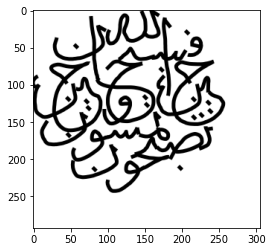

In [19]:
drawing = json.load(open(file))
data, flag = convert_3d(drawing, return_flag=True, threshold=10000)
plt.imshow(draw_strokes(data, stroke_width = 5))
plt.show()

server/larger_data/1فسبحان الله حين تمسون وحين تصبحون.json


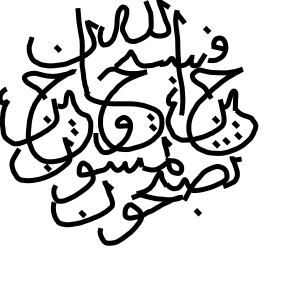

In [8]:
import glob
from IPython.display import SVG, display
import svgwrite
print(file)
num_sketches = 1 

drawing = json.load(open(file))
draw_strokes(convert_3d(drawing), stroke_width = 5)

In [9]:
import re
word_drawings = generate_words(file)
images = []
for i, comp in enumerate(word_drawings):
    word, drawing = list(comp.items())[0]
    images.append(draw_strokes(convert_3d(drawing), square = True, stroke_width = 5))
concatenate(images)

NameError: name 'generate_words' is not defined

In [10]:
char_drawings = generate_characters(file)
images = []
for i, comp in enumerate(char_drawings):
    char, drawing = list(comp.items())[0]
    images.append(draw_strokes(convert_3d(drawing), square = True, stroke_width = 7))
concatenate(images)

NameError: name 'generate_characters' is not defined

In [11]:
drawing = json.load(open(file))

In [12]:
images = []
drawing = json.load(open(file))
for i, comp in enumerate(drawing):
    images.append(draw_strokes(convert_3d(drawing[i:i+1]), square = True, stroke_width = 7))
concatenate(images)

NameError: name 'concatenate' is not defined

In [13]:
def apply_rdb(drawing, verbose = 0):
    new_drawing = []
    total_prev_strokes = 0
    total_post_strokes = 0
    for item in drawing:
        char = list(item.keys())[0]
        stroke = item[char]
        processed_stroke = []
        if len(stroke):
            if verbose:
                print('processing ', char)
            post_stroke = rdp(stroke, epsilon = 2.0)
            total_post_strokes += len(post_stroke)
            total_prev_strokes += len(stroke)
        new_drawing.append({char:post_stroke})
    if verbose:
        print('reduced from ', total_prev_strokes, ' to ', total_post_strokes)
    return new_drawing

In [14]:
#https:#jrgraphix.net/r/Unicode/0600-06FF
map_chars = {
    "\u0623":["\u0621", "\u0627"], # أ
    "\u0622":["\u0605", "\u0627"], # آ
    "\u0625":["\u0627", "\u0621"], # إ
    "\u0628":["\u066E", "."], # ب
    "\u062A":[".", ".", "\u066E"], # ت
    "\u062B":[".", ".", ".", "\u066E"], # ث 
    "\u062C":["\u062D", "."], # ج
    "\u062E":[".", "\u062D"], # خ
    "\u0630":[".", "\u062F"], # ذ
    "\u0632":[".", "\u0631"], # ز
    "\u0634":[".", ".", ".", "\u0633"], # ش
    "\u0636":[".", "\u0635"], # ض
    "\u0637":["\u0627", "\uFEBB"], # ط
    "\u0638":[".", "\u0627", "\uFEBB"], # ظ
    "\u063A":[".", "\u0639"], # غ
    "\u0641":[".", "\u066F"], # ف
    "\u0642":[".", ".", "\u066F"], # ق
    "\u06A4":[".", ".", ".", "\u066F"], # ڤ
    "\u0643":["\u0621", "\u0644"], # ك
    "\u0646":[".", "\u06BA"], # ن
    "\u0624":["\u0621", "\u0648"], # ؤ
    "\u064A":["\u0649", ".", "."], #ي
    "\u0626":["\u0621", "\u0649"], #ئ
    "\u0629":[".", ".", "\u0647"], #ه
}

In [15]:
def preprocess(text):
    char_comps = []
    
    diacritics = "[ًٌٍَُِّْ]"
    numbers = '0123456789'
    for diac in diacritics: 
        text = text.replace(diac, '')

    for num in numbers: 
        text = text.replace(num, '')
    
    outText = ""
    
    for i in range(len(text)):
    
        if (text[i] == " "):
            continue
    
        if text[i] in map_chars:
            if (i < len(text) - 1 and text[i] == "\u0643"):
                if text[i+1] != ' ':
                    char_comps.append({text[i] : '\uFEDB'})
                else:
                    char_comps.append({text[i] : map_chars[text[i]]})
            else:
                char_comps.append({text[i] : map_chars[text[i]]})
        else:
                char_comps.append({text[i] : text[i]})

    return char_comps

In [221]:
def concatenate(images, mode='h', margin=10):
    widths, heights = zip(*(i.size for i in images))
    if mode =='h':
        total_width = sum(widths)
        max_height = max(heights)

        new_im = Image.new('RGB', (total_width, max_height), (255, 255, 255))

        x_offset = 0
        for im in images[::-1]:
            new_im.paste(im, (x_offset,0))
            x_offset += im.size[0]
    elif mode == 'v':    
        total_height = sum(heights)
        max_width = max(widths)

        new_im = Image.new('RGB', (max_width, total_height+margin*(len(images)-1)), (255, 255, 255))
        draw = ImageDraw.Draw(new_im)
        y_offset = 0
        for im in images:
            new_im.paste(im, (0,y_offset+margin))
            y_offset += im.size[1]
            draw.line((0,y_offset+margin-5, max_width,y_offset+margin-5), fill=(0, 0, 0), width=3)
    return new_im

In [198]:
def generate_characters(file):
    char_drawings = []
    annot = file.split('/')[-1][:-5]
    char_comps = preprocess(annot)
    drawing = json.load(open(file))
    new_drawing = apply_rdb(drawing, verbose = 0)
    i = 0 
    for comp in char_comps:
        char = list(comp.keys())[0]
        j = i + len(comp[char])
        char_drawings.append({char:new_drawing[i:j]})
        i = j 
    return char_drawings

In [18]:
import glob
npy_files = glob.glob('server/larger_data/*')
file = np.random.choice(npy_files)

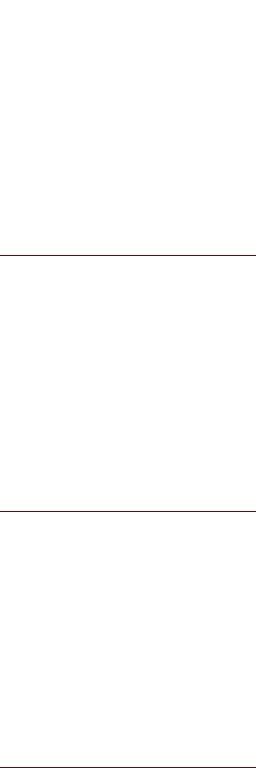

In [163]:
char_drawings = generate_characters(file)
images = []
for i, comp in enumerate(char_drawings):
    char, drawing = list(comp.items())[0]
    images.append(draw_strokes(convert_3d(drawing), square = True))
concatenate(images, mode='v')

In [20]:
def generate_words(file):
    word_drawings = []
    annot = file.split('/')[-1][:-5]
    annot = re.sub('[0-9]', '', annot)
    char_comps = preprocess(annot)
    indices = [m.start() - i - 1 for i, m in enumerate(re.finditer(' ', annot))]
    indices = indices + [len(annot) - len(indices)- 1]
    drawing = json.load(open(file))
#     new_drawing = apply_rdb(drawing, verbose = 0)
    i, j  = 0, 0
    c = 0
    word = ""
    for cntr, comp in enumerate(char_comps):
        char = list(comp.keys())[0]
        j += len(comp[char])
        word += char
        if cntr == indices[c]:
            word_drawings.append({word:drawing[i:i+j]})
            i = i+j
            j = 0 
            c += 1
            word = ""
    return word_drawings

In [21]:
word_drawings = defaultdict(lambda  :[]) 
npy_files = glob.glob('server/larger_data/*')

word_drawings = defaultdict(lambda  :[]) 

for file in npy_files:
    drawings = generate_words(file)
    for i, comp in enumerate(drawings):
        word, drawing = list(comp.items())[0]
        img, res = draw_strokes(convert_3d(drawing), square = True, return_res = True, stroke_width = 5)
        if res[0] > 100 and res[1] > 100:
            word_drawings[word].append(img)

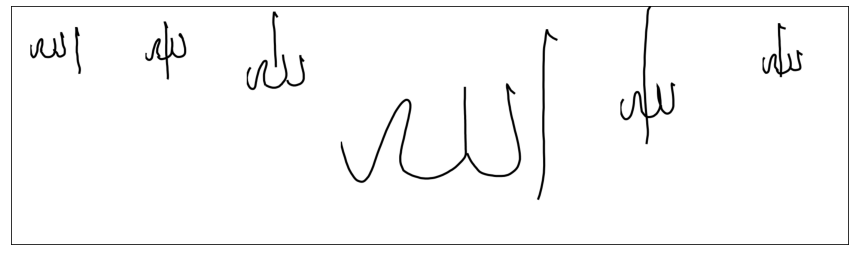

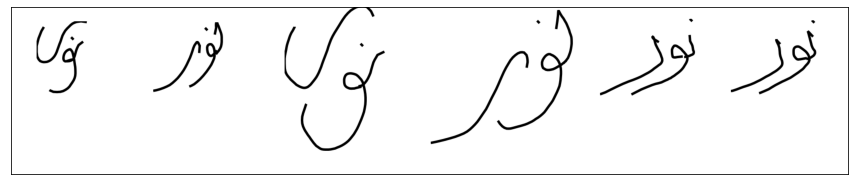

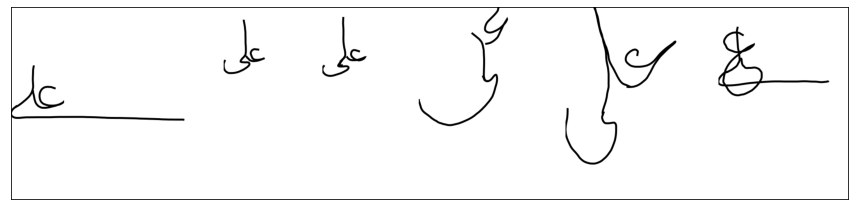

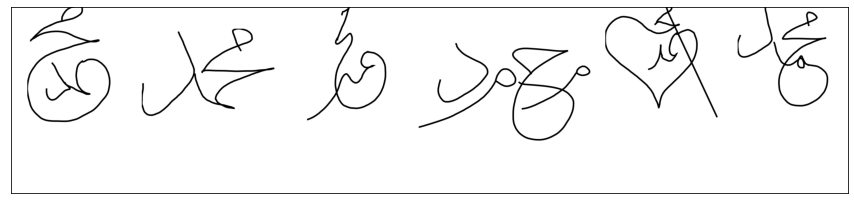

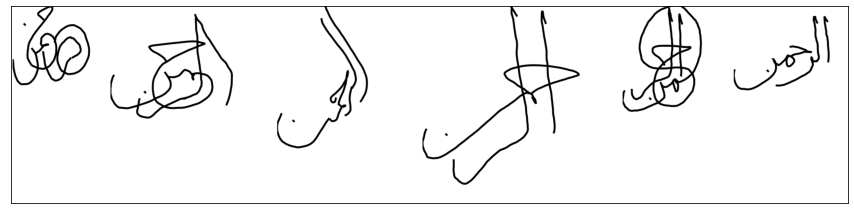

In [22]:
cnt = 0 
for word in ['الله', 'نور', 'على', 'محمد', 'الرحمن']:
    if len(word_drawings[word]) > 10:
        plt.figure(figsize = (15,15))
        plt.imshow(concatenate(word_drawings[word][:6]))
        plt.xticks([])
        plt.yticks([])
        plt.show()
        cnt += 1
    if cnt >= 5:
        break

In [224]:
npy_files = glob.glob('server/larger_data/*')

char_drawings = defaultdict(lambda  :[]) 

for file in npy_files:
    drawings = generate_characters(file)
    images = []
    for i, comp in enumerate(drawings):
        char, drawing = list(comp.items())[0]
        img, res = draw_strokes(convert_3d(drawing, threshold=50), square = True, return_res = True, stroke_width = 5)
#         if res[0] > 100 and res[1] > 100:
        char_drawings[char].append(img)

In [225]:
imgs = []
for char in char_drawings:
    img = concatenate(char_drawings[char][:20],)
    imgs.append(img)

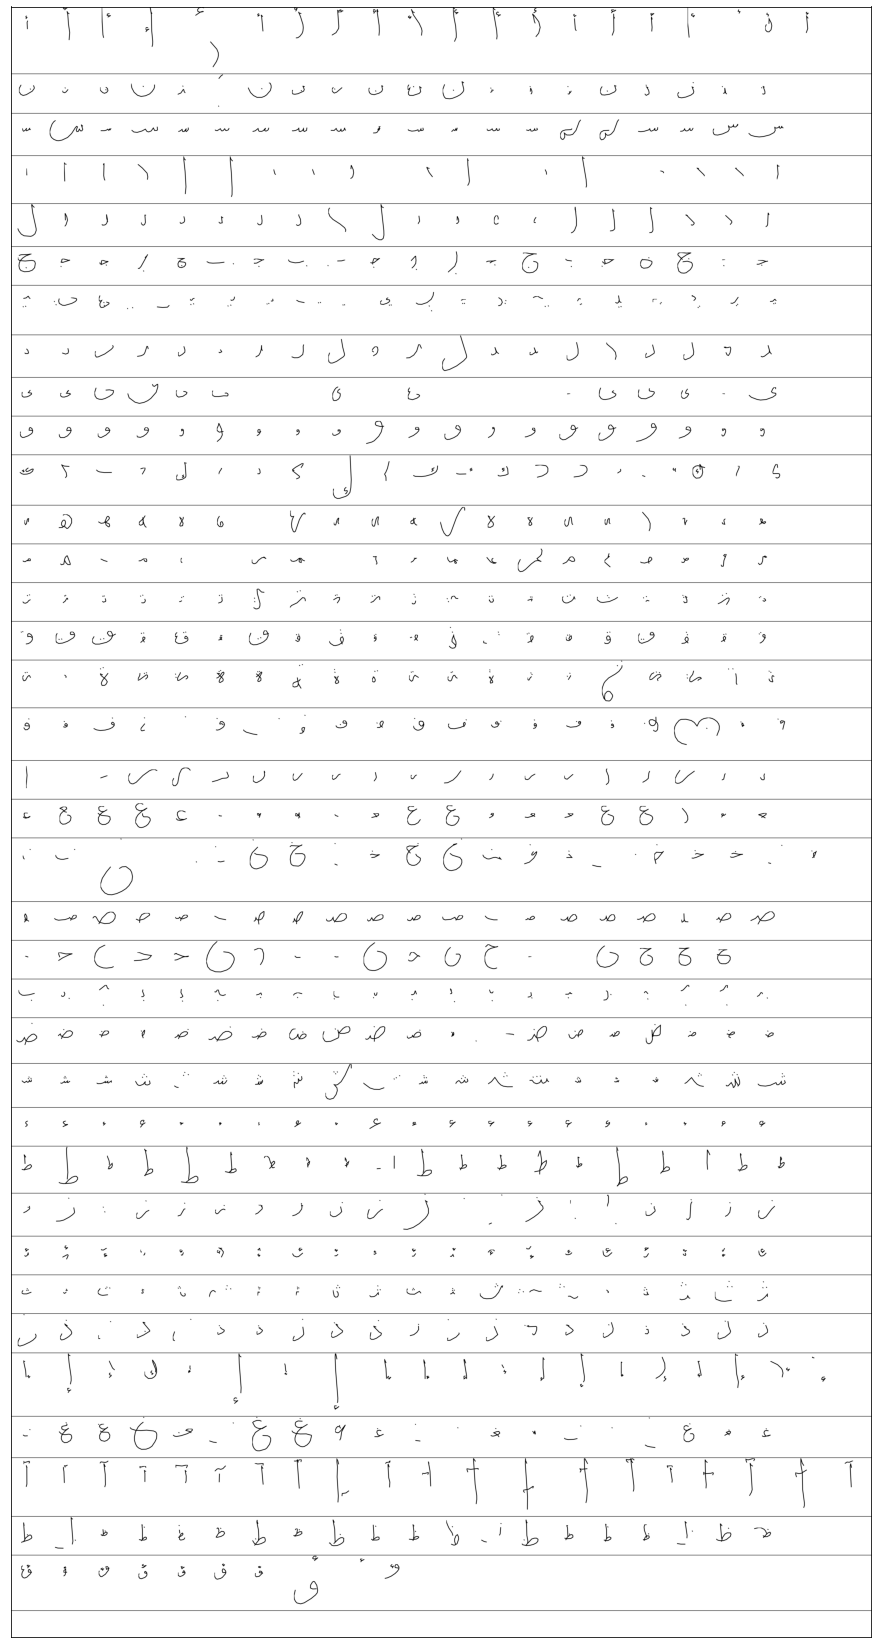

In [226]:
plt.figure(figsize = (40,30))
plt.xticks([])
plt.yticks([])
plt.imshow(concatenate(imgs,'v',margin=5))

In [28]:
list(char_drawings.keys())[-1]

'ء'

In [12]:
npy_files = glob.glob('server/larger_data/*')

images = []
for file in npy_files:
    if 'بسم الله الرحمن الرحيم' in file:
        drawing = json.load(open(file))
        img, res = draw_strokes(convert_3d(drawing), square = True, return_res = True, stroke_width = 5)
        images.append(img)

In [15]:
def map_axes(i, num_sketches = 16):
    sqrt = int(math.sqrt(num_sketches))
    x = np.array(list(range(num_sketches))).reshape((sqrt, sqrt)) 
    dim1, dim2 = np.where(x == i)
    return (int(dim1), int(dim2))

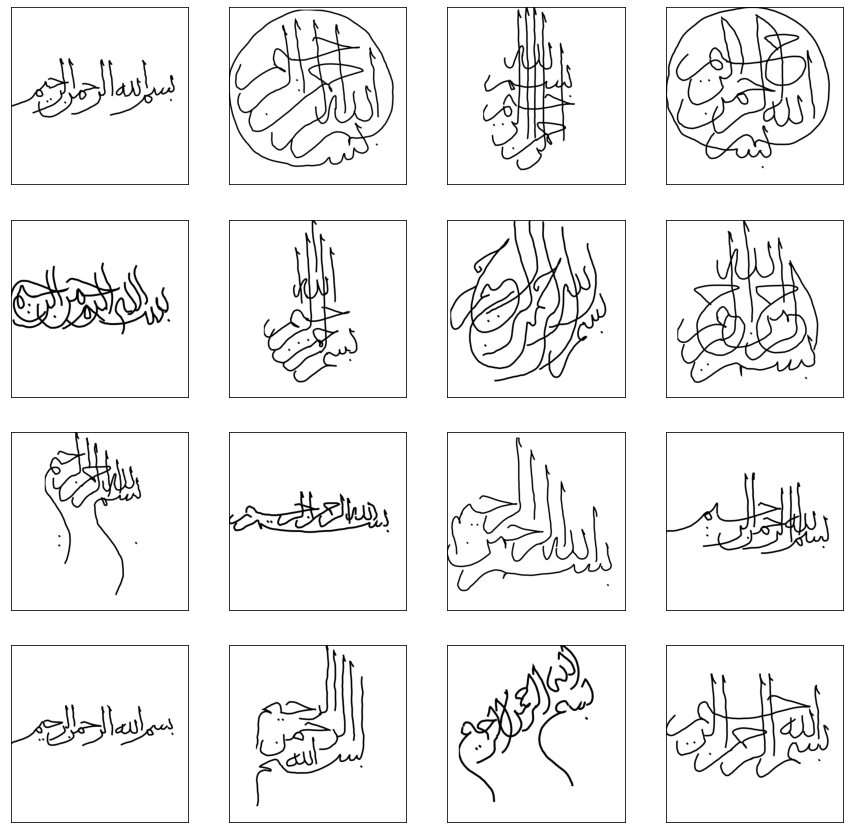

In [27]:
fig, axes = plt.subplots(4, 4, figsize=(15,15))
indices = [0, 1, 17, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12 , 13, 14, 15]
for i, j in enumerate(indices):
    ax = axes[map_axes(i, num_sketches = 16)]
    ax.imshow(images[j])
    ax.set_xticks([])
    ax.set_yticks([])

In [36]:
import pprint

drawing = json.load(open('server/larger_data/22خالد.json'))
drawing = apply_rdb(drawing)
for stroke in drawing:
    pprint.pprint(stroke)

{'.': [[332, 124]]}
{'ح': [[331, 150], [336, 149], [354, 169], [318, 169]]}
{'ا': [[321, 170], [315, 169], [308, 162], [303, 124]]}
{'ل': [[286, 119], [286, 157], [282, 163], [268, 163]]}
{'د': [[250, 144], [260, 156], [264, 172], [259, 176], [244, 176], [238, 171]]}


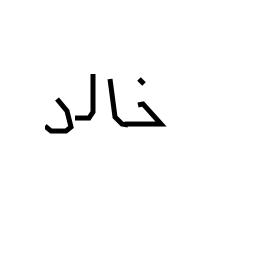

In [38]:
draw_strokes(convert_3d(drawing), square = True, return_res = True, stroke_width = 5)[0]

In [131]:
num_chars = 0 
num_words = 0 
num_strks = 0 
num_sents = 0 

for file in glob.glob('server/larger_data/*')+glob.glob('server/data/*'):
    text = re.sub('[0-9]', '', file.split('/')[-1][:-5])
    for char in text:
        if char in map_chars:
            num_strks += len(map_chars[char])
        else:
            num_strks += 1
            
    num_chars += len(text.replace(' ', ''))
    num_words += len(text.split(' '))
    num_sents += 1

print('number of words ', num_words)
print('number of characters ', num_chars)
print('number of strokes ', num_strks)
print('number of sentences', num_sents)

number of words  3026
number of characters  16777
number of strokes  24861
number of sentences 1414


In [309]:
import os
for file in wrong_annotations:
    file_name = file.split('/')[-1][:-5]
    try:
        os.remove(file)  
        shutil.move(f'server/static/processed_larger_images/{file_name}.jpg', f'server/static/larger_images/{file_name}.jpg')
    except:
        print('already removed')

already removed
